<a href="https://colab.research.google.com/github/kleeena/vvai-fyp/blob/main/VVAI_AS_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VVAI Interface

In [ ]:
prompt = 'A purple tshirt' # @param {type:"string"}
text_prompt_weight = 1. # @param {type:"number"}
# Fix camera so it's not moving around
fix_camera = True
# Speed at which to try approximating the text. Too fast seems to give strange results. Maximum is 100.
speed = 20  # @param {type:"integer"}
# How many steps to run. Each step generates one frame.
steps = 20 # @param {type:"integer"}
# Change the seed to generate variations of the same prompt
seed = 21 # @param {type:"integer"}
# We haven't completely understood which parameters influence the generation of this model. Changing the learning rate could help (between 0 and 100)
learning_rate = 10 # @param {type:"integer"}
social = False
smoothing = (100.0-speed)/100.0


# Clone and import necessities

In [ ]:
!git clone https://github.com/kleeena/vvai-fyp.git
!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP
!pip install openai-clip
!pip install -r '/content/vvai-fyp/requirements_final.txt'

Cloning into 'vvai-fyp'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 26 (delta 10), reused 20 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 11.96 KiB | 11.96 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 212 (delta 99), reused 90 (delta 90), pack-reused 49 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 2.54 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 256 (delta 126), reused 110 (delta 110), pack-reused 102 (from 1)
Receiving objects: 100% (256/256), 8.86 MiB | 14.95 MiB/s, done.
Resolving delt

In [ ]:
import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan3')

import tensorflow
import io
import os, time
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
import gdown

# Download Our Pretrained Models

In [ ]:
!mkdir vvai-fyp/Trained_Models

# Download the pre-trained models
file_ids = ['1M6jn8uz1d4p39E9u55yZysglAllfX5UF', '1MJ61mZcjvL3exQ0Bbr5FdFzRzu3rVRJS']
output_paths = ['vvai-fyp/Trained_Models/TrainedStyleGAN3.pkl', 'vvai-fyp/Trained_Models/TrainedCLIP.pth']
for i in range(len(file_ids)):
    gdown.download(id=file_ids[i], output=output_paths[i], quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1M6jn8uz1d4p39E9u55yZysglAllfX5UF
From (redirected): https://drive.google.com/uc?id=1M6jn8uz1d4p39E9u55yZysglAllfX5UF&confirm=t&uuid=b3cecff7-19c3-433d-8e89-72014860e15a
To: /content/vvai-fyp/Trained_Models/TrainedStyleGAN3.pkl
100%|██████████| 343M/343M [00:08<00:00, 38.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1MJ61mZcjvL3exQ0Bbr5FdFzRzu3rVRJS
From (redirected): https://drive.google.com/uc?id=1MJ61mZcjvL3exQ0Bbr5FdFzRzu3rVRJS&confirm=t&uuid=9dc45964-f228-40a1-bac0-a78fad7c6233
To: /content/vvai-fyp/Trained_Models/TrainedCLIP.pth
100%|██████████| 605M/605M [00:23<00:00, 25.6MB/s]


# Run CLIP and StyleGAN Configurations

In [ ]:
device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)
torch.manual_seed(seed)

#Define necessary functions
def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds

Using device: cuda:0


In [ ]:
import torch
import clip
import torchvision.transforms as transforms

class CLIP(object):
    def __init__(self, clip_model_path, device='cuda'):
        clip_model_name = "ViT-B/32"
        self.device = device
        # Load the CLIP model architecture
        self.model, _ = clip.load(clip_model_name, device=device)
        self.model = self.model.requires_grad_(False)
        self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                              std=[0.26862954, 0.26130258, 0.27577711])

        # Load the trained model weights
        self.load_trained_model(clip_model_path)

    def load_trained_model(self, clip_model_path):
        try:
            state_dict = torch.load(clip_model_path, map_location=self.device)
            self.model.load_state_dict(state_dict)
            print("Trained CLIP model loaded successfully.")
        except Exception as e:
            print(f"Error loading trained CLIP model: {e}")
            raise e

    @torch.no_grad()
    def embed_text(self, prompt):
        "Normalized clip text embedding."
        return norm1(self.model.encode_text(clip.tokenize(prompt).to(self.device)).float())

    def embed_cutout(self, image):
        "Normalized clip image embedding."
        return norm1(self.model.encode_image(self.normalize(image.to(self.device))))

# Example usage:
clip_model_path = '/content/vvai-fyp/Trained_Models/TrainedCLIP.pth'
clip_model = CLIP(clip_model_path)


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 84.9MiB/s]


Trained CLIP model loaded successfully.


In [ ]:
import pickle

class StyleGAN(object):
    def __init__(self, model_path, device='cuda'):
        # Load StyleGAN model
        with open(model_path, 'rb') as fp:
            self.G = pickle.load(fp)['G_ema'].to(device)

        self.device = device
        self.w_stds = None  # Define w_stds as an attribute

    def fix_camera(self):
        # Fix the coordinate grid to w_avg
        shift = self.G.synthesis.input.affine(self.G.mapping.w_avg.unsqueeze(0))
        self.G.synthesis.input.affine.bias.data.add_(shift.squeeze(0))
        self.G.synthesis.input.affine.weight.data.zero_()

    def generate_images(self, num_images):
        # Generate images
        zs = torch.randn([num_images, self.G.mapping.z_dim], device=self.device)
        ws = self.G.mapping(zs, None)  # Mapping network
        return self.G.synthesis(ws)  # Synthesis network

# Example usage:
model_path = '/content/vvai-fyp/Trained_Models/TrainedStyleGAN3.pkl'
stylegan_model = StyleGAN(model_path)

# Optionally fix camera (if needed)
stylegan_model.fix_camera()

# Global variable definition
global G, w_stds
G = stylegan_model.G
device = stylegan_model.device

# Calculate w_stds globally
zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)


Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


# Generate

Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
tensor([0.8788, 0.8900, 0.8568, 0.8785, 0.7863, 0.9040, 0.8654, 0.8526],
       device='cuda:0')
torch.Size([8]) torch.Size([8, 16, 512])


  0%|          | 0/20 [00:00<?, ?it/s]

tensor([0.7829], device='cuda:0', grad_fn=<AddBackward0>)


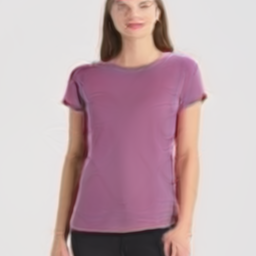

tensor([0.7531], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.8490], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.7353], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.8067], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.7835], device='cuda:0', grad_fn=<AddBackward0>)


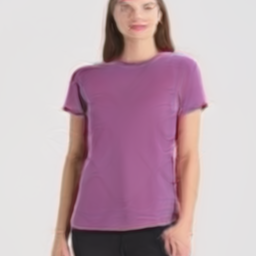

tensor([0.7398], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.7250], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.7155], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.7088], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.7072], device='cuda:0', grad_fn=<AddBackward0>)


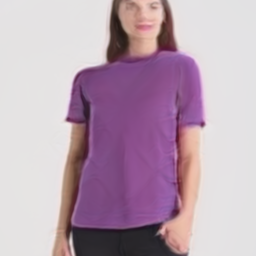

tensor([0.6966], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6984], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6983], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6981], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6923], device='cuda:0', grad_fn=<AddBackward0>)


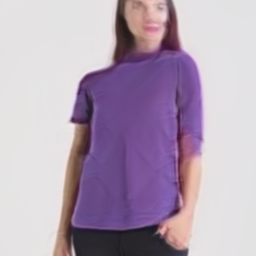

tensor([0.6926], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6911], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6909], device='cuda:0', grad_fn=<AddBackward0>)
tensor([0.6885], device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
# Actually do the run
from IPython.display import display

promptoo= prompt
target = clip_model.embed_text(promptoo)
prompts = [(text_prompt_weight, target)]
output_path = './output'
tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

def run():
  torch.manual_seed(seed)
  timestring = time.strftime('%Y%m%d%H%M%S')

  with torch.no_grad():
    qs = []
    losses = []
    for _ in range(8):
      q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
      images = G.synthesis(q * w_stds + G.mapping.w_avg)
      embeds = embed_image(images.add(1).div(2))
      loss = 0
      for (w, t) in prompts:
        loss += w * spherical_dist_loss(embeds, t).mean(0)
      i = torch.argmin(loss)
      qs.append(q[i])
      losses.append(loss[i])
    qs = torch.stack(qs)
    losses = torch.stack(losses)
    print(losses)
    print(losses.shape, qs.shape)
    i = torch.argmin(losses)
    q = qs[i].unsqueeze(0).requires_grad_()

  #Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=learning_rate/250.0, betas=(0.0,0.999))
  loop = tqdm(range(steps))
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = 0
    for (w, t) in prompts:
      loss += w * spherical_dist_loss(embed, t).mean(0)
    print(loss)
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * smoothing + q * (1-smoothing)
    latent = q_ema * w_stds + G.mapping.w_avg
    image = G.synthesis(latent, noise_mode='const')

    #if i % 10 == 0:
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    os.makedirs(output_path, exist_ok=True)
    os.makedirs("/tmp/ffmpeg", exist_ok=True)
    if i % 5 == 0:
      pil_image.save(f'{output_path}/output_{i:04}.jpg')
      display(pil_image)
    pil_image.save(f'/tmp/ffmpeg/output_{i:04}.jpg')
  return latent

try:
  latent = run()
  torch.save(latent, f"{output_path}/latent.pt")
except KeyboardInterrupt:
  pass